# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1UKqoWYQNnedz_74wCQVTvcVV6Q9jcSdj/view?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

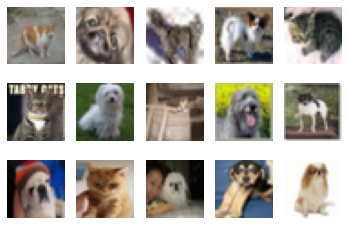

In [5]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
print("Training Examples: ", len(train_loader))
print("Validation Examples: ", len(val_loader))
print("Testing Examples: ", len(test_loader))

Training Examples:  8000
Validation Examples:  2000
Testing Examples:  2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [ ]:
"""
If we only judge the performance of our models using the training set, the model will 
start to overfit to the training data and stray away from actually identifying cats
and dogs in general. We use a validation set to adjust our model and retrain 
using the training set.
"""

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [6]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [7]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [17]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [9]:
from numpy.ma.core import size
print("Small NN Parameters:")
for param in small_net.parameters():
    print(param.shape)

# Small Net: 5*3*3*3 + 5 + 1*245 + 1 = 386

print("\nLarge NN Parameters:")
for param in large_net.parameters():
    print(param.shape)

# Large Net: 5*3*5*5 + 5 + 10*5*5*5 + 10 + 32*250 + 32 + 1*32 + 1 = 9705

Small NN Parameters:
torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])

Large NN Parameters:
torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

In [10]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [ ]:
"""
The default values of the parameters are:
batch_size = 64
learning_rate = 0.01
num_epochs = 30
"""

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
SmallNet_1 = SmallNet()
train_net(SmallNet_1, num_epochs=5)

# The following 5 files are written to the main directory
# and contain each epochs' parameter values/ model weights:
#
# model_small_bs64_lr0.01_epoch0: checkpoint at epoch 0
# model_small_bs64_lr0.01_epoch1: checkpoint at epoch 1
# model_small_bs64_lr0.01_epoch2: checkpoint at epoch 2
# model_small_bs64_lr0.01_epoch3: checkpoint at epoch 3
# model_small_bs64_lr0.01_epoch4: checkpoint at epoch 4

# The following 4 files are written to the main directory and contain 
# the training and validation error and loss from the final epoch:
#
# model_small_bs64_lr0.01_epoch4_train_err.csv: training error
# model_small_bs64_lr0.01_epoch4_train_loss.csv: training loss
# model_small_bs64_lr0.01_epoch4_val_err.csv: validation error
# model_small_bs64_lr0.01_epoch4_val_loss.csv: validation loss

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.415375, Train loss: 0.670185649394989 |Validation err: 0.37, Validation loss: 0.6514860149472952
Epoch 2: Train err: 0.36125, Train loss: 0.6439669713973999 |Validation err: 0.377, Validation loss: 0.657435892149806
Epoch 3: Train err: 0.348875, Train loss: 0.6300341081619263 |Validation err: 0.3495, Validation loss: 0.6222464125603437
Epoch 4: Train err: 0.337875, Train loss: 0.6165080904960633 |Validation err: 0.354, Validation loss: 0.6242818050086498
Epoch 5: Train err: 0.32575, Train loss: 0.6065622324943543 |Validation err: 0.325, Validation loss: 0.611550921574235
Finished Training
Total time elapsed: 30.74 seconds


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [11]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
train_net(small_net)
train_net(large_net)
# small_net is faster, because it has fewer parameters than large_net, so it
# takes less time to do the training
#
# Small NN: 134.56 sec
# Large NN: 156.93 sec
# Surprising, despite the much large number of parameters in the large NN, the
# time difference isn't that large.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

Training Curve for Small Network:


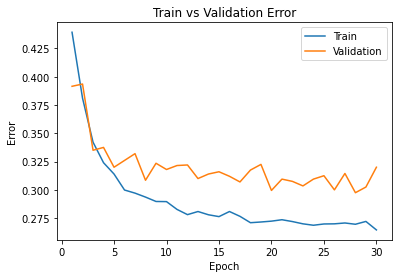

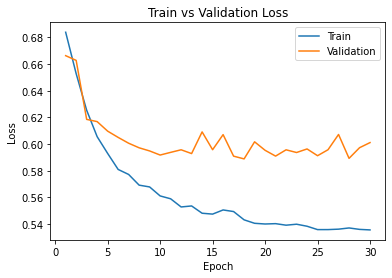

Training Curve for large Network:


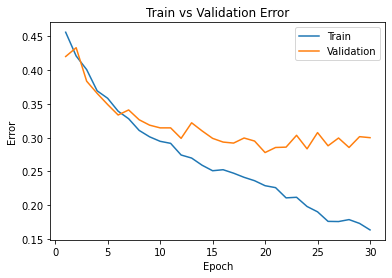

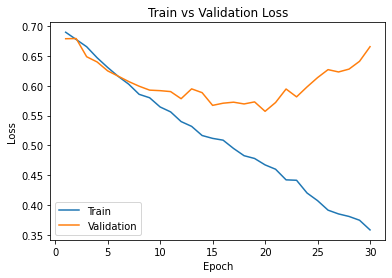

In [19]:
print("Training Curve for Small Network:")
model_path_S = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_S)
print("Training Curve for large Network:")
model_path_L = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_L)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [ ]:
# For the Small NN, we seem to get some underfitting at the start,
# the error and loss both goes down with each additional epoch
# for both training and validation. Eventually, we do see some plateauing but no 
# overfitting yet.

# But for the Large NN, though we seem to see some underfitting at the beginning
# and we see the training error and loss also going down with each additional epoch, 
# we unfortunately see that for validation, error eventually does plateau, 
# and the loss actually seems to increases after around epoch 20,
# which is a sign of overfitting to the training set.

# Overall, the large net gets a lower final training and validation error and loss.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

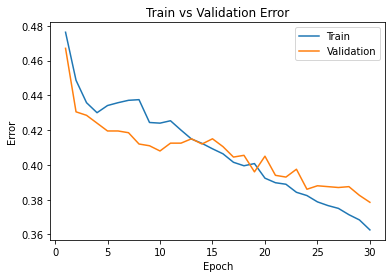

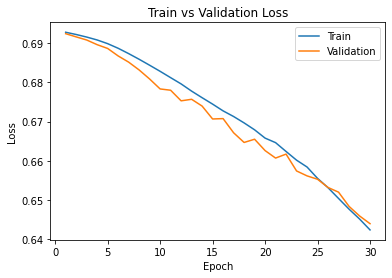

In [20]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, 64, 0.001, 30)
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_large)

# The model takes around the same time to train since the learning rate mainly
# affects the amount at which the models adjusts its weights.
# 
# Lowering the learning rate results in higher error and higher loss in
# training data compared to a lr of 0.01. In validation, the error is higher, 
# but the loss shows no signs of overfitting. 
# Essentially, 0.001 seems too slow for training the model.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

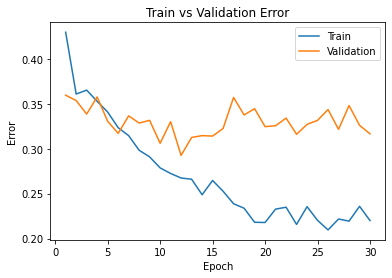

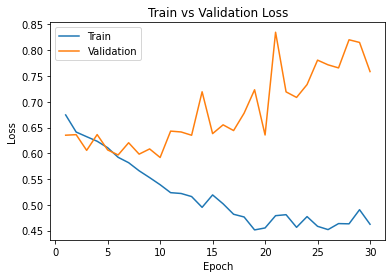

In [21]:
large_net = LargeNet()
train_net(large_net, 64, 0.1, 30)
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path_large)

# As before, the model takes around the same time to train. Since the learning rate mainly
# affects the amount at which the models adjusts its weights.
# 
# Increasing the learning rate makes the model get higher error 
# and higher loss in both the training and validation set, 
# The Validation error and loss increases quickly and jump around after around epoch 15,
# which is a sign of overfitting. 
# A learning rate of 0.1 is too fast in this case.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

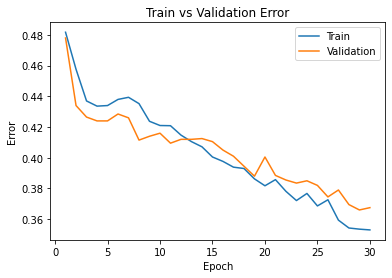

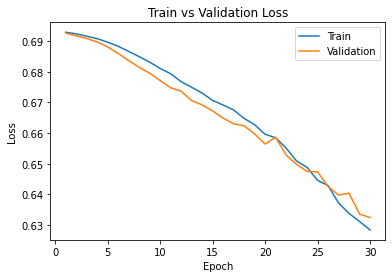

In [22]:
large_net = LargeNet()
train_net(large_net, 512, 0.01, 30)
model_path_large = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

# The model now takes less time to train.
# This is because of the increased batch size which increases the number of 
# training examples used per optimization step/iteration,
# which means that for each epoch, there is a smaller total number of iteration.
#
# Increasing the batch size makes the model get higher error and higher loss in
# training data than the default batch size. 
# And for validation, the error and loss are around the same value compared to the default.
#
# Though here, we see no signs of overfitting. But the decreasing loss of the 
# validation data set is too small.
# This batch_size seems to be a bit too large.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

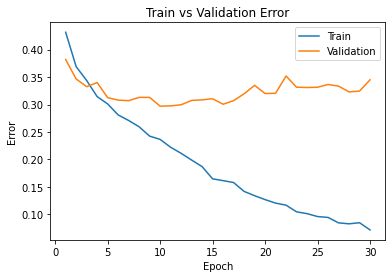

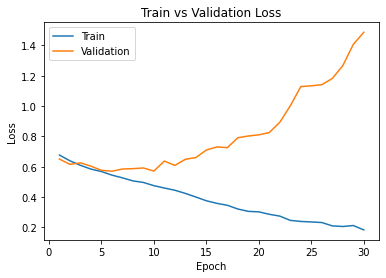

In [23]:
large_net = LargeNet()
train_net(large_net, 16, 0.01, 30)
model_path_large = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

# With the decreased batch_size, the model now takes longer to train than the default batch_size.
# This is due to the increased number of iterations resulting in each epoch taking longer.
#
# With a lower batch_size, we see a lower error and lower loss with the training data set. 
# But, with the validation data set, we see higher error and an incresing loss with each epoch.
# This is a sign of overfitting likely due to the small batch size making the model
# more so memorize the model than identify cats/dogs in general.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [ ]:
# My chosen parameters: 
# network = large_net
# batch_size = 256
# learning_rate = 0.01
# epoch = 30
 
# From the initial test, we saw that the large NN had a smaller error and loss
# at the start (before the large NN started to overfit);

# From testing the lr, it seems like 0.01 is a good learning rate, going to far in 
# increasing or decreasing the lr has negative impacts on training the model,
# there might be a better lr close to this like 0.015, but that's a future concern;

# From testing different batch sizes, when it is small, the model tend to overfitting,
# and when it is large, we see no sign of overfitting but the loss decreases too slowly.
# Therefore, a batch_size of 256 (between 64 and 512) may be a good value.

# The default number of epoch of 30 seems good. We see the loss flattening around here.
# If it is too small, we will see underfitting,
# and uf it is too large, we will see overfitting.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.504, Train loss: 0.694011740386486 |Validation err: 0.4715, Validation loss: 0.6925566866993904
Epoch 2: Train err: 0.455375, Train loss: 0.6913719363510609 |Validation err: 0.424, Validation loss: 0.6898768916726112
Epoch 3: Train err: 0.435375, Train loss: 0.6885282509028912 |Validation err: 0.4205, Validation loss: 0.686040386557579
Epoch 4: Train err: 0.424625, Train loss: 0.6835071798413992 |Validation err: 0.4185, Validation loss: 0.6799078956246376
Epoch 5: Train err: 0.421125, Train loss: 0.6772986091673374 |Validation err: 0.409, Validation loss: 0.6730506420135498
Epoch 6: Train err: 0.40675, Train loss: 0.6715615149587393 |Validation err: 0.4015, Validation loss: 0.6689667105674744
Epoch 7: Train err: 0.388125, Train loss: 0.6626836936920881 |Validation err: 0.379, Validation loss: 0.6593648418784142
Epoch 8: Train err: 0.385125, Train loss: 0.6555437333881855 |Validation err: 0

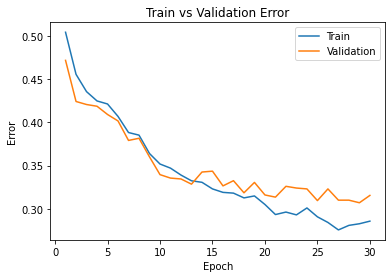

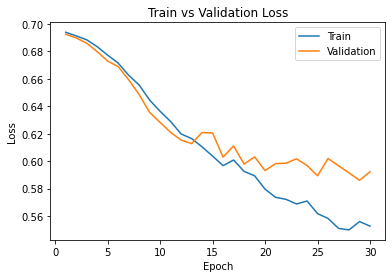

In [27]:
large_net = LargeNet()
train_net(large_net, 256, 0.01, 30)
model_path_large = get_model_name("large", batch_size=256, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [ ]:
# My new chosen parameters: 
# network = large_net
# batch_size = 128
# learning_rate = 0.012
# epoch = 30
 
# I have increased the learning rate a bit as we see no signs of over fitting
# I have also reduced the batch size to hopefully increase the decrease in loss.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.44825, Train loss: 0.691808421460409 |Validation err: 0.4225, Validation loss: 0.6888818927109241
Epoch 2: Train err: 0.439125, Train loss: 0.6863207656239706 |Validation err: 0.417, Validation loss: 0.6800182536244392
Epoch 3: Train err: 0.417375, Train loss: 0.678412399594746 |Validation err: 0.412, Validation loss: 0.6695855595171452
Epoch 4: Train err: 0.398875, Train loss: 0.6697994820655339 |Validation err: 0.398, Validation loss: 0.6620188914239407
Epoch 5: Train err: 0.386, Train loss: 0.6596346279931447 |Validation err: 0.386, Validation loss: 0.6511647067964077
Epoch 6: Train err: 0.365375, Train loss: 0.6462826142235408 |Validation err: 0.3795, Validation loss: 0.6402678675949574
Epoch 7: Train err: 0.36175, Train loss: 0.6377827052086119 |Validation err: 0.36, Validation loss: 0.6300922073423862
Epoch 8: Train err: 0.35075, Train loss: 0.6254830795621115 |Validation err: 0.365,

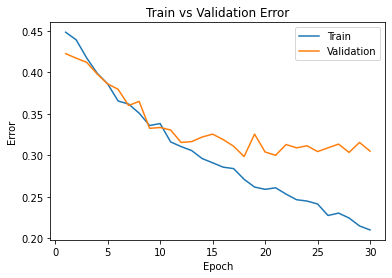

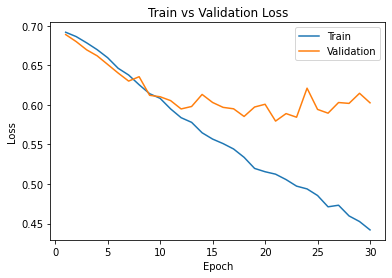

In [31]:
large_net = LargeNet()
train_net(large_net, 128, 0.012, 30)
model_path_large = get_model_name("large", batch_size=128, learning_rate=0.012, epoch=29)
plot_training_curve(model_path_large)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [32]:
net = LargeNet()
train_net(net, 128, 0.012, 21)
model_path = get_model_name("large", batch_size=128, learning_rate=0.012, epoch=20)
state = torch.load(model_path)
net.load_state_dict(state)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.44825, Train loss: 0.691808421460409 |Validation err: 0.4225, Validation loss: 0.6888818927109241
Epoch 2: Train err: 0.439125, Train loss: 0.6863207656239706 |Validation err: 0.417, Validation loss: 0.6800182536244392
Epoch 3: Train err: 0.417375, Train loss: 0.678412399594746 |Validation err: 0.412, Validation loss: 0.6695855595171452
Epoch 4: Train err: 0.398875, Train loss: 0.6697994820655339 |Validation err: 0.398, Validation loss: 0.6620188914239407
Epoch 5: Train err: 0.386, Train loss: 0.6596346279931447 |Validation err: 0.386, Validation loss: 0.6511647067964077
Epoch 6: Train err: 0.365375, Train loss: 0.6462826142235408 |Validation err: 0.3795, Validation loss: 0.6402678675949574
Epoch 7: Train err: 0.36175, Train loss: 0.6377827052086119 |Validation err: 0.36, Validation loss: 0.6300922073423862
Epoch 8: Train err: 0.35075, Train loss: 0.6254830795621115 |Validation err: 0.365,

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [ ]:
# From my latest model, I see the lowest validation error and loss on epoch 21 
# out of the other models.
# Validation error: 0.300
# Validation loss: 0.579

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [33]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(target_classes=["cat", "dog"], batch_size=128)

criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(net, test_loader, criterion)
print("Test classification error & loss: ", test_err, test_loss) 

Files already downloaded and verified
Files already downloaded and verified
Test classification error & loss:  0.291 0.5570533685386181


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
# The test classification error is somehow smaller than the validation error.

# This is unexpected since with each iterarion, we are training our model with the
# training set, and validated with the validation set, the model is gradually 
# becoming a good fit for the training dataset and we stop training when we get 
# a good validation error. This specified training of the model with the training
# and validation set should result in a higher test classification error. As it
# was never seen or used by the model.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [ ]:
# We keep the test data aside and they are not used in any way, 
# which means it is a good data set to evaluate how good our model 
# actually is at classify cats and dogs. 
# If we use the test data in any way, it will affect the model 
# and it may 'memorize' a bit of the test data and thus 
# it won't be able to truly measure the accuracy of the model.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.423625, Train loss: 0.6732779536396265 |Validation err: 0.396, Validation loss: 0.6564163491129875
Epoch 2: Train err: 0.3805, Train loss: 0.6484026610851288 |Validation err: 0.3895, Validation loss: 0.6508420407772064
Epoch 3: Train err: 0.366625, Train loss: 0.6362212598323822 |Validation err: 0.3815, Validation loss: 0.6489596590399742
Epoch 4: Train err: 0.3585, Train loss: 0.6278365030884743 |Validation err: 0.3875, Validation loss: 0.6504446268081665
Epoch 5: Train err: 0.349625, Train loss: 0.6210001818835735 |Validation err: 0.3825, Validation loss: 0.6450524106621742
Epoch 6: Train err: 0.336875, Train loss: 0.6130423974245787 |Validation err: 0.3875, Validation loss: 0.6481978595256805
Epoch 7: Train err: 0.332375, Train loss: 0.6056976336985826 |Validation err: 0.376, Validation loss: 0.6462835296988487
Epoch 8: Train err: 0.31675, Train loss: 0.598584245890379 |Validation err: 

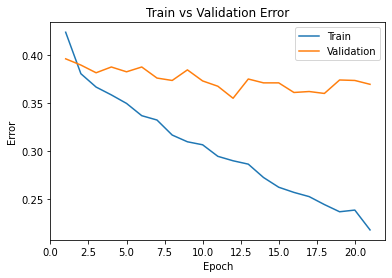

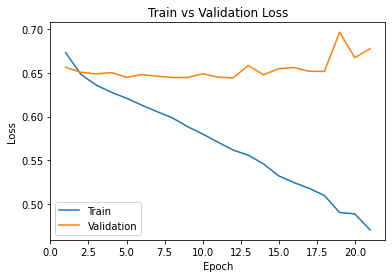

Files already downloaded and verified
Files already downloaded and verified
Test classification error & loss: 0.3545 0.665071614086628


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.layer1 = nn.Linear(3*32*32, 30)
        self.layer2 = nn.Linear(30, 1)
        self.name = "ANN"
    def forward(self, img):
        flattened = img.view(-1, 3*32*32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2.squeeze()

ANN_model = Pigeon()
train_net(ANN_model, 256, 0.012, 21)
model_path_ANN = get_model_name("ANN", batch_size=256, learning_rate=0.012, epoch=20)
plot_training_curve(model_path_ANN)

train_loader, val_loader, test_loader, classes = get_data_loader(target_classes=["cat", "dog"], batch_size = 256)

criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(ANN_model, test_loader, criterion)
print("Test classification error & loss:", test_err, test_loss) 

# We see a larger and fairly stagnent validation error and loss with the ANN model.
# And as expected, we see a larger test classification error and loss.
# Therefore CNN is better for this problem especially since here, we aren't just
# looking for 'patterns', but 'features' that can be found anythere and in any
# orientation (etc.) within each image.